In [2]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from alertstacker.blazar_catalogue import blazars

In [3]:
# hdul = fits.open("data/gll_psc_v19.fit")
# cat = hdul["LAT_Point_Source_Catalog"].data
# cat = np.sort(cat, order="Flux1000")[::-1]

In [4]:
print(list(set(blazars["CLASS1"])))

['fsrq', 'bll', 'FSRQ', 'BLL']


In [5]:
print(blazars.dtype.names)

('Source_Name', 'RAJ2000', 'DEJ2000', 'GLON', 'GLAT', 'Conf_68_SemiMajor', 'Conf_68_SemiMinor', 'Conf_68_PosAng', 'Conf_95_SemiMajor', 'Conf_95_SemiMinor', 'Conf_95_PosAng', 'ROI_num', 'Extended_Source_Name', 'Signif_Avg', 'Pivot_Energy', 'Flux1000', 'Unc_Flux1000', 'Energy_Flux100', 'Unc_Energy_Flux100', 'SpectrumType', 'PL_Flux_Density', 'Unc_PL_Flux_Density', 'PL_Index', 'Unc_PL_Index', 'LP_Flux_Density', 'Unc_LP_Flux_Density', 'LP_Index', 'Unc_LP_Index', 'LP_beta', 'Unc_LP_beta', 'LP_SigCurv', 'PLEC_Flux_Density', 'Unc_PLEC_Flux_Density', 'PLEC_Index', 'Unc_PLEC_Index', 'PLEC_Expfactor', 'Unc_PLEC_Expfactor', 'PLEC_Exp_Index', 'Unc_PLEC_Exp_Index', 'PLEC_SigCurv', 'Npred', 'Flux_Band', 'Unc_Flux_Band', 'nuFnu', 'Sqrt_TS_Band', 'Variability_Index', 'Frac_Variability', 'Unc_Frac_Variability', 'Signif_Peak', 'Flux_Peak', 'Unc_Flux_Peak', 'Time_Peak', 'Peak_Interval', 'Flux_History', 'Unc_Flux_History', 'Sqrt_TS_History', 'ASSOC_FGL', 'ASSOC_FHL', 'ASSOC_GAM1', 'ASSOC_GAM2', 'ASSOC_GAM

Text(0.5, 0, 'Log$_{10}$(Flux)')

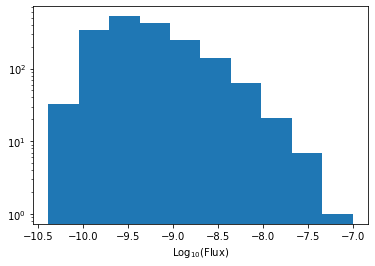

In [6]:
plt.hist(np.log10(blazars["Flux1000"]), log=True)
plt.xlabel(r"Log$_{10}$(Flux)")

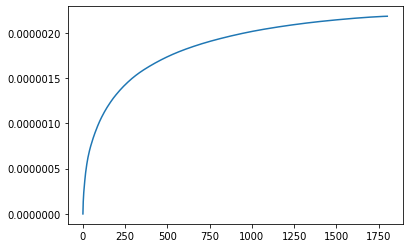

In [7]:
sum_flux = [sum(blazars["Flux1000"][:i]) for i, _ in enumerate(blazars["Flux1000"])]
plt.plot(range(len(blazars)), sum_flux)

In [8]:
print(blazars["ASSOC1"][:15])

['3C 454.3' 'PKS 1424-41' 'PKS 1510-089' 'Mkn 421' '3C 279' 'PKS 0426-380'
 'S5 0716+71' 'PKS 0537-441' 'PKS 0454-234' 'PKS 2155-304' 'BL Lac'
 '4C +21.35' 'PKS 1502+106' 'CTA 102' '3C 66A']


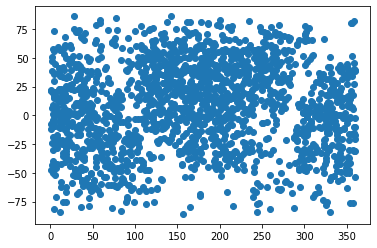

In [9]:
plt.scatter(blazars["RAJ2000"], blazars["DEJ2000"])

NSIDE = 1024, Max Pixel Radius = 0.059800825955419704 deg
[0, 1, 2, 3, 4]


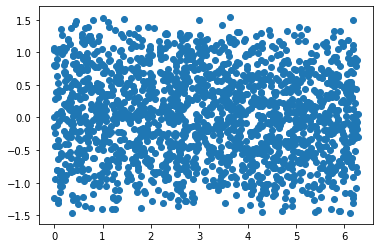

In [10]:
import healpy as hp
import random

nside = 1024
print("NSIDE = {0}, Max Pixel Radius = {1} deg".format(nside, np.degrees(hp.max_pixrad(nside))))

gal_plane = []
cone_ids = [x for x in range(hp.nside2npix(nside)) if x not in gal_plane]

print(cone_ids[:5])

def extract_ra_dec(nside, index):
    (colat, ra) = hp.pix2ang(nside, index, nest=True)
    dec = np.pi / 2. - colat
    return (ra, dec)

data_dtype = np.dtype([
    ("Flux", np.float),
    ("Ra", np.float),
    ("Dec", np.float)
])

def scramble_catalogue(flux_vals):
    cat = []
    indexes = np.random.choice(len(cone_ids), size=len(flux_vals))
    res = extract_ra_dec(nside, indexes)
    
    sim_cat = np.array([(f, res[0][i], res[1][i]) for i, f in enumerate(flux_vals)], dtype=data_dtype)
    return sim_cat
    
cat = scramble_catalogue(blazars["Flux1000"])

plt.scatter(cat["Ra"], cat["Dec"])

In [11]:
from scipy.stats import norm

nu_dtype = np.dtype([
    ("Time", np.float),
    ("Ra", np.float),
    ("Dec", np.float)
])

class NeutrinoAlert:
    
    def __init__(self, time, ra, dec, signalness=0.5):
        self.time = time
        self.ra = float(ra)
        self.dec = float(dec)
        self.signalness = 1.
        
    def eval_spatial_pdf(self, ra, dec):
        raise NotImplementedError
    
    @staticmethod
    def angular_distance(lon1, lat1, lon2, lat2):
        """calculate the angular distince along the great circle
        on the surface of a shpere between the points
        (`lon1`,`lat1`) and (`lon2`,`lat2`)
        This function Works for equatorial coordinates
        with right ascension as longitude and declination
        as latitude. This function uses the Vincenty formula
        for calculating the distance.
        Parameters
        ----------
        lon1 : array_like
          longitude of first point in radians
        lat1 : array_like
          latitude of the first point in radians
        lon2 : array_like
          longitude of second point in radians
        lat2 : array_like
          latitude of the second point in radians
        """
        c1 = np.cos(lat1)
        c2 = np.cos(lat2)
        s1 = np.sin(lat1)
        s2 = np.sin(lat2)
        sd = np.sin(lon2 - lon1)
        cd = np.cos(lon2 - lon1)

        return np.arctan2(
            np.hypot(c2 * sd, c1 * s2 - s1 * c2 * cd),
            s1 * s2 + c1 * c2 * cd
        )


        
class CircularisedNeutrinoAlert(NeutrinoAlert):
    
    def __init__(self, time, ra, ra_delta, dec, dec_delta, signalness=0.5):
        NeutrinoAlert.__init__(self, time, ra, dec, signalness=1.)
        self.sigma = np.sqrt(0.25*(ra_delta[0]**2 + ra_delta[1]**2 + dec_delta[0]**2 + dec_delta[1]**2))
        
    @staticmethod
    def gaussian(delta, sigma):
        return norm.pdf(x=delta, scale=sigma)**2
    
    @staticmethod
    def bkg_spatial():
        return 1. / (4. * np.pi)
   
    def eval_spatial_pdf(self, ra, dec):
        delta = self.angular_distance(np.radians(ra), np.radians(dec), np.radians(self.ra), np.radians(self.dec))
        return self.gaussian(delta, self.sigma) / self.bkg_spatial()
        


def parse_neutrino_alerts():
    nu_cat = []
    nu_objs = []
    with open("data/catalog_of_alerts.txt", "r") as f:
        for line in f.readlines():
            if line[0] not in ["#", "\n"]:
                if "retracted" not in line:                 
                    vals = [x for x in line.split(" ") if x not in [""]]
                    time = vals[0]
                    ra = vals[1]
                    dec = vals[3]
                    ra_delta = [float(x) for x in vals[2][1:-1].split(",")]
                    dec_delta = [float(x) for x in vals[4][1:-2].split(",")]
                    nu_objs.append(CircularisedNeutrinoAlert(time, ra, ra_delta, dec, dec_delta))
                    nu_cat.append((vals[0], vals[1], vals[3]))
                    
    return np.array(nu_cat, dtype=nu_dtype), nu_objs

nu_cat, nu_obj = parse_neutrino_alerts()
print()

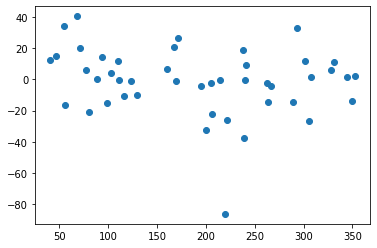

In [12]:
plt.scatter(nu_cat["Ra"], nu_cat["Dec"])